## Combine semester data into one file

In [1]:
# First let's combine the individual semester files into one big file
# This code is from https://github.com/ekapope/Combine-CSV-files-in-the-folder/blob/master/Combine_CSVs.py

import os
import glob
import pandas as pd
import matplotlib.pyplot 
import numpy as np
import matplotlib.pyplot as plt


# This is the path to the folder with the data files
os.chdir("/Users/briandomino/Documents/Miami/MUR enrollment data")

In [2]:
extension = 'csv'
all_filenames = [i for i in glob.glob('*Semester*.{}'.format(extension))]

# Be careful not to have files in this directory with "Semester" in their names
# that you don't want loaded into the dataset

In [3]:
#combine all files in the list
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])

#export to csv
combined_csv.to_csv( "combined enrollment data.csv", index=False, encoding='utf-8-sig')

In [4]:
# This is where you would begin if you've already done the merging
# but have made some changes to the code below

df = pd.read_csv("combined enrollment data.csv")

## Clean the data

In [5]:
# remove the columns we're not interested in
df.drop(["CRN", "Business Surcharge", "Description", "Meeting Dates", "Cross-List Sections", "Course Level",
         "Meeting Days", "Meeting Times", "Meeting Locations", "Special Approval", "Grade Mode",
         "Additional Notes", "Attribute Description"], axis = 'columns', inplace = True) 

In [6]:
# Remove instructor's first name and
# change fee of "None" to 0
# r is the row and we're going through all the rows one-by-one

# Rather than give a column number, I'm going to calculate it so it doesn't matter
# if it later changes

index_no_of_instructor = df.columns.get_loc('Instructors')
index_no_of_fees = df.columns.get_loc('Estimated Fees')

for r in range(len(df)) :
    name = (df.iloc[r, index_no_of_instructor])
    name = name.split(',')[0]
    df.iloc[r, index_no_of_instructor] = name
    
    if df.iloc[r, index_no_of_fees] == 'None':
        df.iloc[r, index_no_of_fees] = '0'

In [7]:
# Remove the $ in the fees column as it prevents later calculations

df[df.columns[index_no_of_fees]] = df[df.columns[index_no_of_fees]].replace('[\$,]', '', regex=True).astype(float)

In [8]:
df.sort_values(by=['Term'], ascending=False, inplace = True)

In [9]:
# Save the cleaned data
df.to_csv("cleaned combined enrollment data.csv", index=False)

## Calculate efficiency and add it to the dataframe

In [10]:
df['Efficiency'] = df['Enrollment'] / df['Capacity']

In [11]:
# Move Efficiency to be between Capacity and Credit Hours

index_no_of_Credit_Hours = df.columns.get_loc('Credit Hours')
cols = list(df.columns)
df = df[cols[0:index_no_of_Credit_Hours] + [cols[-1]] + cols[index_no_of_Credit_Hours:-1]]

## Calculate credit hour production and add it to the dataframe

In [12]:
df['CH Prod'] = df['Enrollment'] * df['Credit Hours']

# Move CH Prod to be before Delivery

index_no_of_delivery = df.columns.get_loc('Delivery')
cols = list(df.columns)
df = df[cols[0:index_no_of_delivery] + [cols[-1]] + cols[index_no_of_delivery:-1]]

## Calculate fees generated per class and add it to the dataframe

In [13]:
df['Total Fees'] = df['Enrollment'] * df['Estimated Fees']

## Number of instructors per semester

In [14]:
# This will be used to adjust the credit hour production
no_of_instructors = df.groupby('Term')['Instructors'].nunique()

## Credit hour production per semester

In [15]:
semester_ch_prod = df.groupby('Term')['CH Prod'].sum()

## Fees generated per semester

In [16]:
fees_per_semester = df.groupby('Term')['Total Fees'].sum()

## Calculate efficiency by semester

In [17]:
semester_efficiency = df.groupby('Term')['Enrollment'].sum() / df.groupby('Term')['Capacity'].sum()

## Create a semester-by-semester dataframe from the above calculations

In [18]:
semester_by_semester = pd.concat([semester_ch_prod, no_of_instructors, fees_per_semester,
                                  semester_efficiency.rename('Semester Efficiency')], axis=1).reset_index()

In [19]:
semester_by_semester['CH Prod/Inst'] = semester_by_semester['CH Prod'] / semester_by_semester['Instructors']

In [20]:
# now save this as a spreadsheet

semester_by_semester.to_excel('Revised Data.xlsx', index = False)

## Make some bar charts using the school color

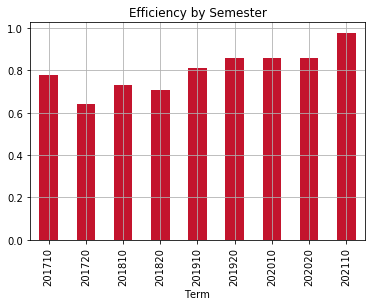

In [21]:
semester_by_semester.plot.bar(x='Term', y='Semester Efficiency', rot = 90, color = '#c3142d',
                              grid = True, legend = False, title = 'Efficiency by Semester')

plt.savefig('Semester Efficiency.png', dpi=300, bbox_inches = "tight") 

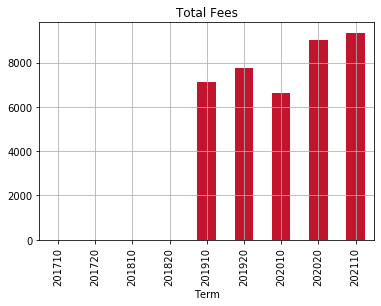

In [22]:
semester_by_semester.plot.bar(x='Term', y='Total Fees', rot = 90, title = 'Total Fees', 
                              color = '#c3142d', grid = True, legend = False)

plt.savefig('Total Fees.png', dpi=300, bbox_inches = "tight") 

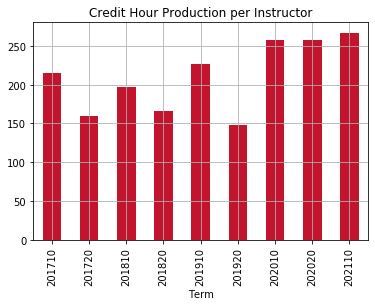

In [23]:
semester_by_semester.plot.bar(x='Term', y='CH Prod/Inst', rot=90, title = 'Credit Hour Production per Instructor',
                              color = '#c3142d', grid = True, legend = False)

plt.savefig('CH prod per instructor.png', dpi=300, bbox_inches = "tight") 